In [2]:
import os.path as osp

import torch
from tqdm import tqdm
import pandas as pd

from torch_geometric.datasets import AmazonBook
from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transactions = pd.read_csv("data/train.csv")
transactions

,Unnamed: 0,customer_id,article_id,year,month,day
0,479507,232477,28866,20,1,18
1,5328148,306128,7094,20,6,18
2,4779175,41132,12896,20,6,4
3,4852517,189305,34181,20,6,6
4,7130496,238987,18606,20,7,31
...,...,...,...,...,...,...
6997367,500812,186580,26577,20,1,19
6997368,4897929,11831,1305,20,6,8
6997369,3916280,255785,1332,20,5,14
6997370,2789100,64400,16263,20,4,9


In [4]:
# customers, articles = torch.LongTensor(transactions.customer_id), torch.LongTensor(transactions.article_id)
# edge_index = torch.stack((torch.cat([customers, articles]), torch.cat([articles, customers])))
# edge_index.shape
edge_index = torch.LongTensor([transactions.customer_id, transactions.article_id])
edge_index

tensor([[232477, 306128,  41132,  ..., 255785,  64400,  91322],
        [ 28866,   7094,  12896,  ...,   1332,  16263,  25534]])

In [5]:
test = pd.read_csv("data/test.csv")
edge_label_index = torch.LongTensor([test.customer_id, test.article_id])

In [6]:
from torch_geometric.data import HeteroData
data = HeteroData()

In [7]:
data['customer', 'purchases', 'article'].edge_index = edge_index
data['customer', 'purchases', 'article'].edge_label_index = edge_label_index

In [8]:
data['article', 'purchased_by', 'customer'].edge_index = edge_index[[1,0]]

In [9]:
print(data)

HeteroData(
  (customer, purchases, article)={
    edge_index=[2, 6997372],
    edge_label_index=[2, 1749343],
  },
  (article, purchased_by, customer)={ edge_index=[2, 6997372] }
)


In [10]:
print(data['customer', 'purchases', 'article'].edge_index)
print(data['article', 'purchased_by', 'customer'].edge_index)

tensor([[232477, 306128,  41132,  ..., 255785,  64400,  91322],
        [ 28866,   7094,  12896,  ...,   1332,  16263,  25534]])
tensor([[ 28866,   7094,  12896,  ...,   1332,  16263,  25534],
        [232477, 306128,  41132,  ..., 255785,  64400,  91322]])


In [11]:
num_customers = transactions.customer_id.nunique()
num_articles = transactions.article_id.nunique()

In [12]:
data['customer'].num_nodes = num_customers
data['article'].num_nodes = num_articles

In [13]:
print(data)

HeteroData(
  customer={ num_nodes=343166 },
  article={ num_nodes=36806 },
  (customer, purchases, article)={
    edge_index=[2, 6997372],
    edge_label_index=[2, 1749343],
  },
  (article, purchased_by, customer)={ edge_index=[2, 6997372] }
)


In [14]:
del(transactions)

In [15]:
data = data.to_homogeneous().to(device)
print(data)

Data(edge_index=[2, 13994744], edge_label_index=[2, 1749343], node_type=[379972], edge_type=[13994744])


In [16]:
from torch_geometric.loader import DataLoader
batch_size = 1024
mask = data.edge_index[0] < data.edge_index[1]
train_edge_label_index = data.edge_index[:, mask]
# train_loader = torch.utils.data.DataLoader(
train_loader = DataLoader(
    range(train_edge_label_index.size(1)),
    shuffle=True,
    batch_size=batch_size,
)

In [17]:
print(data.edge_index.shape)
data.edge_index

torch.Size([2, 13994744])


tensor([[232477, 306128,  41132,  ..., 344498, 359429, 368700],
        [372032, 350260, 356062,  ..., 255785,  64400,  91322]],
       device='cuda:0')

In [18]:
print(train_edge_label_index.shape)
train_edge_label_index

torch.Size([2, 6997372])


tensor([[232477, 306128,  41132,  ..., 255785,  64400,  91322],
        [372032, 350260, 356062,  ..., 344498, 359429, 368700]],
       device='cuda:0')

In [19]:
# import torch_geometric.transforms as T
# data = T.ToSparseTensor(data)
# print(data)

In [20]:
mask

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

In [21]:
mask.sum()

tensor(6997372, device='cuda:0')

In [22]:
data.num_nodes

379972

In [23]:
data.edge_index[0].max()

tensor(379971, device='cuda:0')

In [24]:
model = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=32,
    num_layers=2,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
def train():
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        # Sample positive and negative labels.
        pos_edge_label_index = train_edge_label_index[:, index]
        # print(f"pos:{pos_edge_label_index.shape}\n", pos_edge_label_index)
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_customers, num_customers + num_articles,
                          (index.numel(), ), device=device)
        ], dim=0)
        # print(f"neg:{neg_edge_label_index.shape}\n", neg_edge_label_index)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)
        # print(f"edge: {edge_label_index.shape}\n", edge_label_index)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

In [26]:
@torch.no_grad()
def test(k: int):
    emb = model.get_embedding(data.edge_index)
    customer_emb, article_emb = emb[:num_customers], emb[num_customers:]

    precision = recall = total_examples = 0
    for start in range(0, num_customers, batch_size):
        end = start + batch_size
        logits = customer_emb[start:end] @ article_emb.t()

        # Exclude training edges:
        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_customers] = float('-inf')

        # Computing precision and recall:
        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((data.edge_label_index[0] >= start) &
                (data.edge_label_index[0] < end))
        ground_truth[data.edge_label_index[0, mask] - start,
                     data.edge_label_index[1, mask] - num_customers] = True
        node_count = degree(data.edge_label_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

    return precision / total_examples, recall / total_examples

In [27]:
for epoch in range(1, 101):
    loss = train()
    precision, recall = test(k=20)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Precision@20: '
          f'{precision:.4f}, Recall@20: {recall:.4f}')

100%|██████████| 6834/6834 [09:27<00:00, 12.05it/s]


Epoch: 001, Loss: 0.3758, Precision@20: 0.0031, Recall@20: 0.0136


100%|██████████| 6834/6834 [09:27<00:00, 12.04it/s]


Epoch: 002, Loss: 0.3371, Precision@20: 0.0038, Recall@20: 0.0168


100%|██████████| 6834/6834 [09:27<00:00, 12.03it/s]


Epoch: 003, Loss: 0.3068, Precision@20: 0.0043, Recall@20: 0.0190


100%|██████████| 6834/6834 [09:24<00:00, 12.11it/s]


Epoch: 004, Loss: 0.2791, Precision@20: 0.0050, Recall@20: 0.0218


100%|██████████| 6834/6834 [09:19<00:00, 12.21it/s]


Epoch: 005, Loss: 0.2471, Precision@20: 0.0057, Recall@20: 0.0251


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 006, Loss: 0.2214, Precision@20: 0.0062, Recall@20: 0.0275


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 007, Loss: 0.2049, Precision@20: 0.0065, Recall@20: 0.0291


100%|██████████| 6834/6834 [09:27<00:00, 12.03it/s]


Epoch: 008, Loss: 0.1923, Precision@20: 0.0068, Recall@20: 0.0305


100%|██████████| 6834/6834 [09:16<00:00, 12.29it/s]


Epoch: 009, Loss: 0.1816, Precision@20: 0.0071, Recall@20: 0.0319


100%|██████████| 6834/6834 [09:27<00:00, 12.04it/s]


Epoch: 010, Loss: 0.1720, Precision@20: 0.0074, Recall@20: 0.0333


100%|██████████| 6834/6834 [09:18<00:00, 12.23it/s]


Epoch: 011, Loss: 0.1635, Precision@20: 0.0077, Recall@20: 0.0348


100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]


Epoch: 012, Loss: 0.1559, Precision@20: 0.0080, Recall@20: 0.0361


100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]


Epoch: 013, Loss: 0.1491, Precision@20: 0.0082, Recall@20: 0.0372


100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]


Epoch: 014, Loss: 0.1429, Precision@20: 0.0084, Recall@20: 0.0383


100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]


Epoch: 015, Loss: 0.1370, Precision@20: 0.0087, Recall@20: 0.0394


100%|██████████| 6834/6834 [09:22<00:00, 12.14it/s]


Epoch: 016, Loss: 0.1318, Precision@20: 0.0089, Recall@20: 0.0406


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 017, Loss: 0.1266, Precision@20: 0.0090, Recall@20: 0.0412


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 018, Loss: 0.1225, Precision@20: 0.0092, Recall@20: 0.0420


100%|██████████| 6834/6834 [09:28<00:00, 12.01it/s]


Epoch: 019, Loss: 0.1180, Precision@20: 0.0094, Recall@20: 0.0430


100%|██████████| 6834/6834 [09:17<00:00, 12.26it/s]


Epoch: 020, Loss: 0.1142, Precision@20: 0.0095, Recall@20: 0.0436


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 021, Loss: 0.1105, Precision@20: 0.0097, Recall@20: 0.0444


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 022, Loss: 0.1073, Precision@20: 0.0098, Recall@20: 0.0450


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 023, Loss: 0.1036, Precision@20: 0.0099, Recall@20: 0.0455


100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]


Epoch: 024, Loss: 0.1010, Precision@20: 0.0100, Recall@20: 0.0460


100%|██████████| 6834/6834 [09:17<00:00, 12.25it/s]


Epoch: 025, Loss: 0.0980, Precision@20: 0.0101, Recall@20: 0.0464


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 026, Loss: 0.0959, Precision@20: 0.0102, Recall@20: 0.0469


100%|██████████| 6834/6834 [09:16<00:00, 12.29it/s]


Epoch: 027, Loss: 0.0934, Precision@20: 0.0102, Recall@20: 0.0472


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 028, Loss: 0.0912, Precision@20: 0.0104, Recall@20: 0.0477


100%|██████████| 6834/6834 [09:22<00:00, 12.15it/s]


Epoch: 029, Loss: 0.0890, Precision@20: 0.0104, Recall@20: 0.0477


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 030, Loss: 0.0871, Precision@20: 0.0104, Recall@20: 0.0479


100%|██████████| 6834/6834 [09:16<00:00, 12.28it/s]


Epoch: 031, Loss: 0.0855, Precision@20: 0.0104, Recall@20: 0.0480


100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]


Epoch: 032, Loss: 0.0836, Precision@20: 0.0104, Recall@20: 0.0481


100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]


Epoch: 033, Loss: 0.0824, Precision@20: 0.0104, Recall@20: 0.0480


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 034, Loss: 0.0809, Precision@20: 0.0105, Recall@20: 0.0483


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 035, Loss: 0.0796, Precision@20: 0.0105, Recall@20: 0.0481


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 036, Loss: 0.0784, Precision@20: 0.0104, Recall@20: 0.0481


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 037, Loss: 0.0774, Precision@20: 0.0105, Recall@20: 0.0480


100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]


Epoch: 038, Loss: 0.0764, Precision@20: 0.0104, Recall@20: 0.0479


100%|██████████| 6834/6834 [09:28<00:00, 12.01it/s]


Epoch: 039, Loss: 0.0753, Precision@20: 0.0104, Recall@20: 0.0477


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 040, Loss: 0.0742, Precision@20: 0.0104, Recall@20: 0.0477


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 041, Loss: 0.0736, Precision@20: 0.0104, Recall@20: 0.0476


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 042, Loss: 0.0730, Precision@20: 0.0103, Recall@20: 0.0474


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 043, Loss: 0.0722, Precision@20: 0.0103, Recall@20: 0.0473


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 044, Loss: 0.0717, Precision@20: 0.0103, Recall@20: 0.0471


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 045, Loss: 0.0712, Precision@20: 0.0102, Recall@20: 0.0470


100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]


Epoch: 046, Loss: 0.0707, Precision@20: 0.0102, Recall@20: 0.0468


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 047, Loss: 0.0700, Precision@20: 0.0101, Recall@20: 0.0466


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 048, Loss: 0.0696, Precision@20: 0.0101, Recall@20: 0.0464


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 049, Loss: 0.0692, Precision@20: 0.0101, Recall@20: 0.0463


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 050, Loss: 0.0688, Precision@20: 0.0101, Recall@20: 0.0461


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 051, Loss: 0.0683, Precision@20: 0.0100, Recall@20: 0.0460


100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]


Epoch: 052, Loss: 0.0677, Precision@20: 0.0100, Recall@20: 0.0457


100%|██████████| 6834/6834 [09:34<00:00, 11.89it/s]


Epoch: 053, Loss: 0.0676, Precision@20: 0.0100, Recall@20: 0.0456


 98%|█████████▊| 6672/6834 [09:12<00:13, 12.09it/s]


KeyboardInterrupt: 

amazon = AmazonBook("./data")
amazon = amazon[0]

print(amazon)

print(data)

2380730
13994744

amazon['user','rates','book'].edge_label_index

In [33]:
import re

log_file  = """100%|██████████| 6834/6834 [09:27<00:00, 12.05it/s]
Epoch: 001, Loss: 0.3758, Precision@20: 0.0031, Recall@20: 0.0136
100%|██████████| 6834/6834 [09:27<00:00, 12.04it/s]
Epoch: 002, Loss: 0.3371, Precision@20: 0.0038, Recall@20: 0.0168
100%|██████████| 6834/6834 [09:27<00:00, 12.03it/s]
Epoch: 003, Loss: 0.3068, Precision@20: 0.0043, Recall@20: 0.0190
100%|██████████| 6834/6834 [09:24<00:00, 12.11it/s]
Epoch: 004, Loss: 0.2791, Precision@20: 0.0050, Recall@20: 0.0218
100%|██████████| 6834/6834 [09:19<00:00, 12.21it/s]
Epoch: 005, Loss: 0.2471, Precision@20: 0.0057, Recall@20: 0.0251
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 006, Loss: 0.2214, Precision@20: 0.0062, Recall@20: 0.0275
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 007, Loss: 0.2049, Precision@20: 0.0065, Recall@20: 0.0291
100%|██████████| 6834/6834 [09:27<00:00, 12.03it/s]
Epoch: 008, Loss: 0.1923, Precision@20: 0.0068, Recall@20: 0.0305
100%|██████████| 6834/6834 [09:16<00:00, 12.29it/s]
Epoch: 009, Loss: 0.1816, Precision@20: 0.0071, Recall@20: 0.0319
100%|██████████| 6834/6834 [09:27<00:00, 12.04it/s]
Epoch: 010, Loss: 0.1720, Precision@20: 0.0074, Recall@20: 0.0333
100%|██████████| 6834/6834 [09:18<00:00, 12.23it/s]
Epoch: 011, Loss: 0.1635, Precision@20: 0.0077, Recall@20: 0.0348
100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]
Epoch: 012, Loss: 0.1559, Precision@20: 0.0080, Recall@20: 0.0361
100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]
Epoch: 013, Loss: 0.1491, Precision@20: 0.0082, Recall@20: 0.0372
100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]
Epoch: 014, Loss: 0.1429, Precision@20: 0.0084, Recall@20: 0.0383
100%|██████████| 6834/6834 [09:09<00:00, 12.44it/s]
Epoch: 015, Loss: 0.1370, Precision@20: 0.0087, Recall@20: 0.0394
100%|██████████| 6834/6834 [09:22<00:00, 12.14it/s]
Epoch: 016, Loss: 0.1318, Precision@20: 0.0089, Recall@20: 0.0406
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 017, Loss: 0.1266, Precision@20: 0.0090, Recall@20: 0.0412
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 018, Loss: 0.1225, Precision@20: 0.0092, Recall@20: 0.0420
100%|██████████| 6834/6834 [09:28<00:00, 12.01it/s]
Epoch: 019, Loss: 0.1180, Precision@20: 0.0094, Recall@20: 0.0430
100%|██████████| 6834/6834 [09:17<00:00, 12.26it/s]
Epoch: 020, Loss: 0.1142, Precision@20: 0.0095, Recall@20: 0.0436
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 021, Loss: 0.1105, Precision@20: 0.0097, Recall@20: 0.0444
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 022, Loss: 0.1073, Precision@20: 0.0098, Recall@20: 0.0450
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 023, Loss: 0.1036, Precision@20: 0.0099, Recall@20: 0.0455
100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]
Epoch: 024, Loss: 0.1010, Precision@20: 0.0100, Recall@20: 0.0460
100%|██████████| 6834/6834 [09:17<00:00, 12.25it/s]
Epoch: 025, Loss: 0.0980, Precision@20: 0.0101, Recall@20: 0.0464
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 026, Loss: 0.0959, Precision@20: 0.0102, Recall@20: 0.0469
100%|██████████| 6834/6834 [09:16<00:00, 12.29it/s]
Epoch: 027, Loss: 0.0934, Precision@20: 0.0102, Recall@20: 0.0472
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 028, Loss: 0.0912, Precision@20: 0.0104, Recall@20: 0.0477
100%|██████████| 6834/6834 [09:22<00:00, 12.15it/s]
Epoch: 029, Loss: 0.0890, Precision@20: 0.0104, Recall@20: 0.0477
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 030, Loss: 0.0871, Precision@20: 0.0104, Recall@20: 0.0479
100%|██████████| 6834/6834 [09:16<00:00, 12.28it/s]
Epoch: 031, Loss: 0.0855, Precision@20: 0.0104, Recall@20: 0.0480
100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]
Epoch: 032, Loss: 0.0836, Precision@20: 0.0104, Recall@20: 0.0481
100%|██████████| 6834/6834 [09:29<00:00, 12.00it/s]
Epoch: 033, Loss: 0.0824, Precision@20: 0.0104, Recall@20: 0.0480
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 034, Loss: 0.0809, Precision@20: 0.0105, Recall@20: 0.0483
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 035, Loss: 0.0796, Precision@20: 0.0105, Recall@20: 0.0481
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 036, Loss: 0.0784, Precision@20: 0.0104, Recall@20: 0.0481
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 037, Loss: 0.0774, Precision@20: 0.0105, Recall@20: 0.0480
100%|██████████| 6834/6834 [09:29<00:00, 12.01it/s]
Epoch: 038, Loss: 0.0764, Precision@20: 0.0104, Recall@20: 0.0479
100%|██████████| 6834/6834 [09:28<00:00, 12.01it/s]
Epoch: 039, Loss: 0.0753, Precision@20: 0.0104, Recall@20: 0.0477
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 040, Loss: 0.0742, Precision@20: 0.0104, Recall@20: 0.0477
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 041, Loss: 0.0736, Precision@20: 0.0104, Recall@20: 0.0476
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 042, Loss: 0.0730, Precision@20: 0.0103, Recall@20: 0.0474
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 043, Loss: 0.0722, Precision@20: 0.0103, Recall@20: 0.0473
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 044, Loss: 0.0717, Precision@20: 0.0103, Recall@20: 0.0471
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 045, Loss: 0.0712, Precision@20: 0.0102, Recall@20: 0.0470
100%|██████████| 6834/6834 [09:28<00:00, 12.02it/s]
Epoch: 046, Loss: 0.0707, Precision@20: 0.0102, Recall@20: 0.0468
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 047, Loss: 0.0700, Precision@20: 0.0101, Recall@20: 0.0466
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 048, Loss: 0.0696, Precision@20: 0.0101, Recall@20: 0.0464
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 049, Loss: 0.0692, Precision@20: 0.0101, Recall@20: 0.0463
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 050, Loss: 0.0688, Precision@20: 0.0101, Recall@20: 0.0461
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 051, Loss: 0.0683, Precision@20: 0.0100, Recall@20: 0.0460
100%|██████████| 6834/6834 [09:28<00:00, 12.03it/s]
Epoch: 052, Loss: 0.0677, Precision@20: 0.0100, Recall@20: 0.0457
100%|██████████| 6834/6834 [09:34<00:00, 11.89it/s]
Epoch: 053, Loss: 0.0676, Precision@20: 0.0100, Recall@20: 0.0456
 98%|█████████▊| 6672/6834 [09:12<00:13, 12.09it/s]
"""
pattern = r"Epoch:\s*(\d+),.*Precision@20:\s*([0-9.]+),.*Recall@20:\s*([0-9.]+)"



loss_record = pd.DataFrame(columns=['Precision@20', 'Recall@20'])
for line in log_file.splitlines():
    if line[0] == '1':
        continue
    match = re.search(pattern, line)

    if match:
        epoch = int(match.group(1))  # Convert to integer
        precision = float(match.group(2))  # Convert to float
        recall = float(match.group(3))  # Convert to float
        loss_record.loc[epoch] = [precision, recall]
        # print(f"Epoch: {epoch}, Precision@20: {precision}, Recall@20: {recall}")
    else:
        print("Pattern not found in the string.")
loss_record

Pattern not found in the string.


,Precision@20,Recall@20
1,0.0031,0.0136
2,0.0038,0.0168
3,0.0043,0.0190
4,0.0050,0.0218
5,0.0057,0.0251
6,0.0062,0.0275
7,0.0065,0.0291
8,0.0068,0.0305
9,0.0071,0.0319
10,0.0074,0.0333


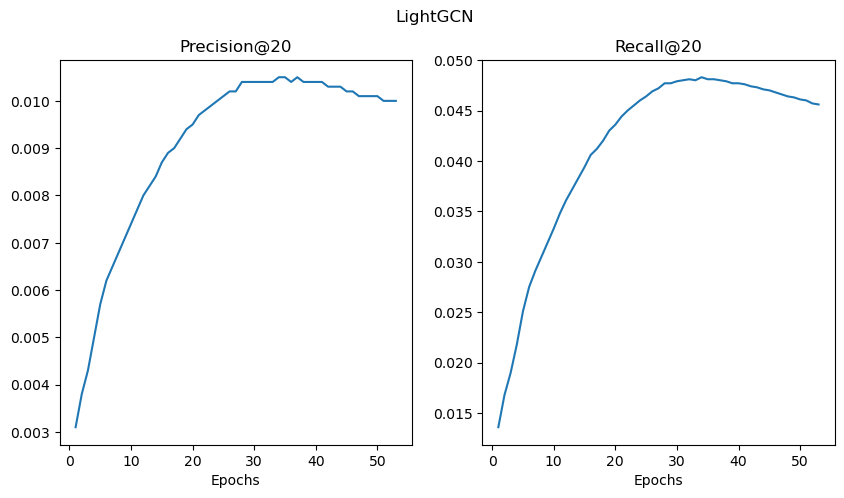

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].plot(loss_record.index, loss_record['Precision@20'])
ax[1].plot(loss_record.index, loss_record['Recall@20'])
ax[0].set_title('Precision@20')
ax[1].set_title('Recall@20')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
fig.suptitle("LightGCN")
plt.show
plt.savefig('LightGCN_results.jpg')